#### Data Source: https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast

In [ ]:
# install fbprophet
!pip install pystan~=2.14 fbprophet

In [ ]:
from google.colab import files
files.upload()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
df = pd.read_csv('/content/drive/MyDrive/Hamoye/Stage-E-files/Time_series_analysis_and_forecast_DATASET.csv')

In [ ]:
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [ ]:
#checking the data types, the "FullDate" feature is discovered to be of type 'object'
df.dtypes

FullDate      object
Tmax         float64
SysLoad      float64
GasPrice     float64
ElecPrice    float64
dtype: object

In [90]:
# converting the "FullDate" feature from string to 'datetime'
df['FullDate'] = pd.to_datetime(df['FullDate'], format='%Y-%m-%d')
df.dtypes

FullDate     datetime64[ns]
Tmax                float64
SysLoad             float64
GasPrice            float64
ElecPrice           float64
dtype: object

In [6]:
#check for null values
df.isnull().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

## Downsample to daily sampling rate

In [91]:
#Downsample to daily data points
df.set_index( "FullDate" , inplace= True )
df_daily = df.resample( 'D', ).sum()

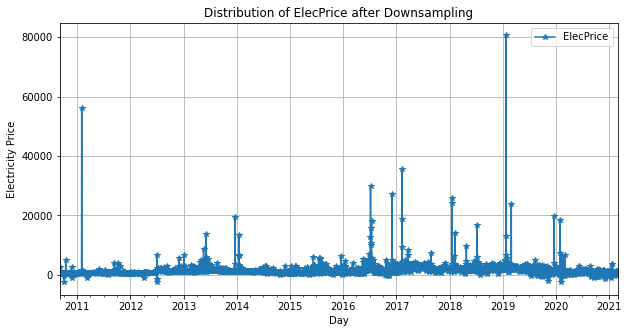

In [93]:
df_daily.ElecPrice.plot(figsize=(10,5), marker='*', label='ElecPrice')
plt.title('Distribution of ElecPrice after Downsampling')
plt.xlabel('Day')
plt.ylabel('Electricity Price')
plt.grid()
plt.legend()
plt.show()

## Question: 
Using the Augmented Dicky Fuller test (ADF), what is the P-value of the SysLoad and GasPrice of the resampled Data set, to 6 decimal places?

In [95]:
from statsmodels.tsa.stattools import adfuller
adf_test_SysLoad = adfuller(df_daily.SysLoad.values)
print('P-value of SysLoad: {:.6f}'.format(adf_test_SysLoad[1]))

adf_test_GasPrice = adfuller(df_daily.GasPrice)
print('P-value of GasPrice: {:.6f}'.format(adf_test_GasPrice[1]))

P-value of SysLoad: 0.004254
P-value of GasPrice: 0.045027


## Question:
Using the Augmented Dicky Fuller test (ADF) what are the 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set, to 4 decimal places?

In [97]:
#solution
gas = adfuller(df_daily.GasPrice.values)
print('10% critical value of GasPrice: {:.4f}'.format(gas[4]['10%']))
print('=='*10)
electric = adfuller(df_daily.ElecPrice.values)
print('5% critical value of ElecPrice: {:.4f}'.format(electric[4]['5%']))

10% critical value of GasPrice: -2.5672
5% critical value of ElecPrice: -2.8623


### Renaming the date and target features as required by fbprophet, and creating train and predict dataframe

In [98]:
# Creating train and predict dataframe
df_daily = df_daily.reset_index().rename(columns={'FullDate':'ds', 'ElecPrice':'y'})
df_train = df_daily[['ds', 'y']].iloc[:2757]

In [99]:
df_train.tail()

,ds,y
2752,2018-03-15,2717.340
2753,2018-03-16,2277.335
2754,2018-03-17,1718.385
2755,2018-03-18,1088.015
2756,2018-03-19,1998.305


In [100]:
from fbprophet import Prophet
# initialize and fit Prophet
model = Prophet()
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [101]:
#predict for the next 1077 days
periods = df_daily.shape[0]-df_train.shape[0]
future = model.make_future_dataframe(periods= periods , freq= 'D' )

forecast = model.predict(future)
#forecast.head()

## Question:
Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

Hint:

Define a function that calculates the Mape using the definition of MAPE from the course Module and pass your dataset into it.

In [102]:
from sklearn.metrics import mean_absolute_percentage_error

yhat = forecast.yhat[2757:]
y_true = df_daily.y[2757:]

mape = mean_absolute_percentage_error(y_true=y_true, y_pred=yhat)
print('MAPE: {:.2f}'.format(mape*100))

MAPE: 549.48


## Question:
What is the RMSE in 2 decimal places?

In [103]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_true, yhat))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 3218.16


## Question:
If you plot the components from the forecasted model, what month of the yearly seasonality has the highest value?

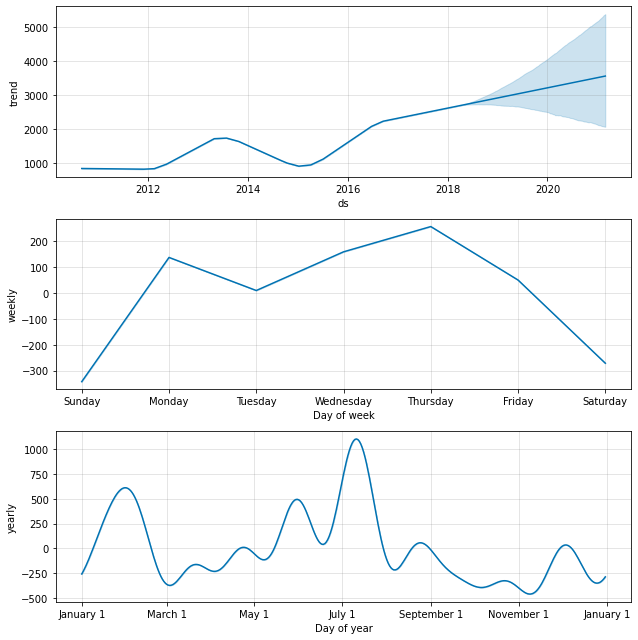

In [106]:
model.plot_components(forecast)
plt.show()

### Adding external regressors

In [107]:
df_train_regr = df_daily[['ds', 'y', 'Tmax', 'SysLoad', 'GasPrice']].iloc[:2757]
df_predict_regr = df_daily[['ds', 'Tmax', 'SysLoad', 'GasPrice']]

In [108]:
# modelling external regressors prior to model fitting
model_regr = Prophet(daily_seasonality=True)

model_regr.add_regressor('SysLoad',)
model_regr.add_regressor('Tmax')
model_regr.add_regressor('GasPrice')

#fit and predict
model_regr.fit(df_train_regr)
forecast_regr = model_regr.predict(df_predict_regr)

## Question:
Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

In [109]:
y_truth = df_daily.y[2757:]
y_hat = forecast_regr.yhat[2757:]

mape_regr = mean_absolute_percentage_error(y_true=y_truth, y_pred=y_hat)
print('MAPE: {:.2f}'.format(mape_regr*100))

MAPE: 232.77


## Question:
What is the RMSE in 2 decimal places?

In [110]:
rmse = np.sqrt(mean_squared_error(y_truth, y_hat))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 2708.40


## Question:
If you plot the components from the multivariate forecasted model, what day of the daily seasonality has the highest value?

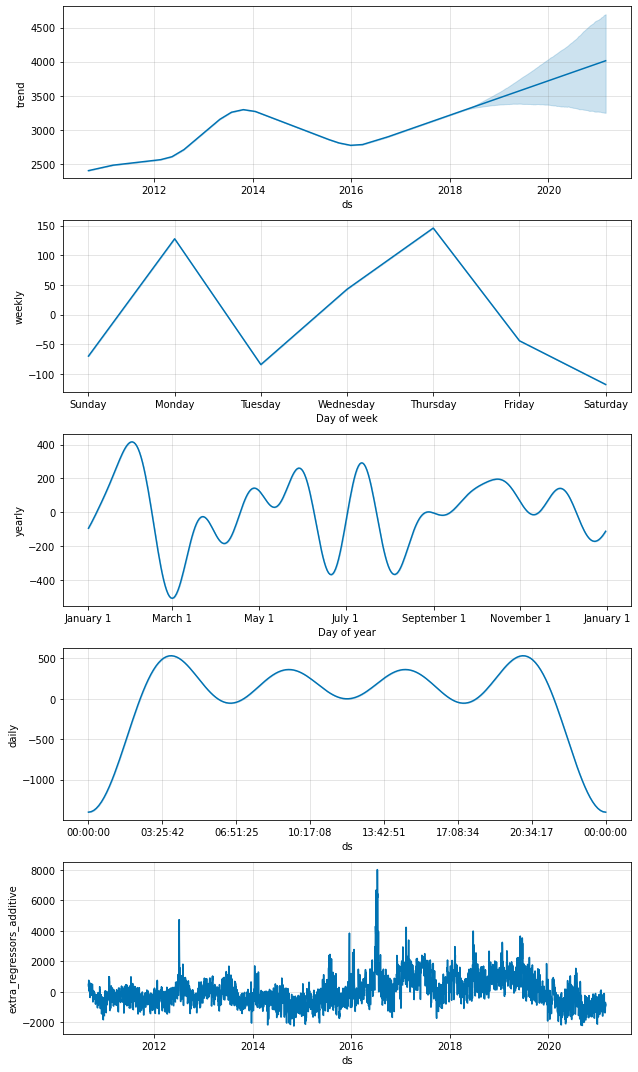

In [111]:
# plot model components
fig2 = model_regr.plot_components(forecast_regr, uncertainty=True)

## Question:
Train a multivariate time series model performing the same train test split as before, but now exclude T-max from the training data(drop T-max),

What is the mean absolute percentage error (MAPE) to 2 decimal places on the test set?

In [116]:
df_train_new = df_daily[['ds', 'y', 'SysLoad', 'GasPrice']].iloc[:2757]
df_predict_new = df_daily[['ds', 'SysLoad', 'GasPrice']]

# modelling external regressors prior to model fitting
model_new = Prophet(daily_seasonality=True)

# adding external regressors, excluding Tmax
model_new.add_regressor('SysLoad',)
model_new.add_regressor('GasPrice')

#fit and predict
model_new.fit(df_train_new)
forecast_new = model_new.predict(df_predict_new)


y_truth = df_daily.y[2757:]
y_hat = forecast_new.yhat[2757:]

mape_new = mean_absolute_percentage_error(y_true=y_truth, y_pred=y_hat)
print('New MAPE without Tmax: {:.2f}'.format(mape_new*100))

New MAPE without Tmax: 235.13
